In [ ]:
!pip install torch
!pip install pyfolio-reloaded
!pip install ta
!pip install sdv

In [1]:
# Import the necessary libraries
import torch
import numpy as np
import pandas as pd
import pyfolio as pf
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from sdv.sequential import PARSynthesizer
from sdv.metadata import Metadata
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

/home/josgt/anaconda3/envs/quantinsti/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
tickers = ['AAPL', 'MSFT']
# Download the Apple stock data
apple = yf.download(tickers[0], start='1990-01-01', end='2024-12-13', auto_adjust=True)
# Create the percentage rets
apple['rets'] = apple['Close'].pct_change()
# Set the signal column
apple['signal'] = 0.0
# Download the Apple stock data
msft = yf.download(tickers[1], start='1990-01-01', end='2024-12-13', auto_adjust=True)
# Create the percentage rets
msft['rets'] = msft['Close'].pct_change()
# Set the signal column
msft['signal'] = 0.0
# Create column with the stock name
apple['stock'] = tickers[0]
# Create column with the stock name
msft['stock'] = tickers[1]
# Concatenate data
data = pd.concat([apple, msft])
# Sort index by datetime
data.sort_index(inplace=True)
# Drop Nan values
data.dropna(inplace=True)
# Print the data
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,rets,signal,stock
Date,,,,,,,,
1990-01-03,0.382465,0.385670,0.378191,0.381397,113774400,0.005635,0.0,MSFT
1990-01-03,0.267407,0.267407,0.263888,0.263888,207995200,0.006711,0.0,AAPL
1990-01-04,0.269167,0.272685,0.262129,0.264769,221513600,0.003337,0.0,AAPL
1990-01-04,0.381397,0.393148,0.379259,0.392614,125740800,0.029412,0.0,MSFT
1990-01-05,0.265649,0.269167,0.260370,0.265649,123312000,0.003323,0.0,AAPL
...,...,...,...,...,...,...,...,...
2024-12-10,246.889999,248.210007,245.339996,247.770004,36914800,0.004134,0.0,AAPL
2024-12-11,444.049988,450.350006,444.049988,448.989990,19200200,0.012767,0.0,MSFT
2024-12-11,247.960007,250.800003,246.259995,246.490005,45205800,-0.005166,0.0,AAPL


In [3]:
def create_datetimes_for_synthetic_data(start, num_of_dates):
    # Create datetime list 
    date_list = [start + dt.timedelta(days=1) for x in range(1,num_of_dates+1)]
        
    return date_list

def create_synthetic_data(seeds_list, symbol, data, sample_num_obs): 

    # Copy the dataframe
    data = data.copy()
    
    # Create synthetic dataframe
    synthetic_data = pd.DataFrame(index = create_datetimes_for_synthetic_data(data[data['stock']=='AAPL'].index[-1], sample_num_obs),
                                  columns=['Close', 'Volume','rets'])
    
    data['context'] = data['stock'].copy()
    fitting_data = data[['stock','Volume','rets','context']].reset_index()

    metadata = Metadata.load_from_dict({
        'tables': {
            'fitting_data': {
                'columns': {
                    'stock': { 'sdtype': 'id' },
                    'Date': { 'sdtype': 'datetime', 'datetime_format': '%Y-%m-%d %H:%M:%S' },
                    'Volume': { 'sdtype': 'numerical'},
                    'rets': { 'sdtype': 'numerical'},
                    'context': { 'sdtype': 'categorical'}
                },
                'sequence_key': 'stock',
                'sequence_index': 'Date'
            }
        }
    })

    synthesizer = PARSynthesizer(
        metadata,
        context_columns=['context'],
        cuda=False,
        epochs = 250,
        verbose=False)

    # Fit the model
    synthesizer.fit(fitting_data)

    synthetic_data_dict = {}

    for seed in seeds_list:
        # Set the random numpy seed
        np.random.seed(seed)

        scenario_context = pd.DataFrame(data={
            'stock': ['AAPL', 'MSFT'],
            'context': ['AAPL', 'MSFT']})

        synthetic_sample = synthesizer.sample_sequential_columns(
            context_columns=scenario_context,
            sequence_length=sample_num_obs)

        synthetic_sample = synthetic_sample[synthetic_sample['stock']==symbol][['Volume','rets']]

        # Subset only the ticker synthetic data
        synthetic_data[['Volume','rets']] = synthetic_sample[['Volume','rets']].values
        # Create the Close price data based on the synthetic return data
        synthetic_data['Close'] = (1+synthetic_data['rets']).cumprod()*data['Close'].iloc[-1]
    
        # Get the High mean return and standard deviation with respect to the Close price
        hc_mean, hc_std = (data['High']/data['Close']-1).mean(), (data['High']/data['Close']-1).std()
        # Get the Low mean return and standard deviation with respect to the Close price
        lc_mean, lc_std = abs(data['Low']/data['Close']-1).mean(), abs(data['Low']/data['Close']-1).std()
    
        # Create the High prices
        synthetic_data['High'] = np.random.lognormal(hc_mean, hc_std, len(synthetic_data.index))*synthetic_data['Close']
        # Create the Low prices
        synthetic_data['Low'] = synthetic_data['Close']/np.random.lognormal(lc_mean, lc_std, len(synthetic_data.index))
        # Create the Open prices
        synthetic_data['Open'] = synthetic_data['Close'].shift(1)
        # Round the High and Low prices to 2 decimals
        synthetic_data = synthetic_data.round(2)

        # Save the synthetic price dataframe into the dictionary
        synthetic_data_dict[seed] = synthetic_data
    
    return synthetic_data_dict

def get_input_features(data):
    data = data.copy()
    # Get the input features based on the available technical indicators
    features = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True).drop(\
                                    ["Open", "High", "Low", "Close", "Volume", "rets"], axis=1)
    
    # Set 2 lists to save indicators names as needed
    indicators_to_become_stationary = list()
    indicators_to_drop = list()
    
    # Loop to check for each indicator's stationarity
    for indicator in features.columns.tolist():
        try:
            # Get the Augmented-Dickey Fuller p-value
            pvalue = adfuller(features[indicator].dropna(), regression='c', autolag='AIC')[1]
            # If p-value is higher than 5%
            if pvalue > 0.05:
                # Save the indicator name to become it stationary later
                indicators_to_become_stationary.append(indicator)
            # I p-value is NaN
            elif np.isnan(pvalue):
                # Save the indicator name to drop it later
                indicators_to_drop.append(indicator)
        except:
            # Save the indicator name to drop it later
            indicators_to_drop.append(indicator)
    
    # Make the respective indicators stationary
    features[indicators_to_become_stationary] = features[indicators_to_become_stationary].pct_change()
    # Drop the respective indicators which p-values where NaN
    features.drop(indicators_to_drop, axis=1, inplace=True)
    
    # Concatenate the input features with the previous dataframe
    data = pd.concat([data, features], axis=1)
    # Set the features columns' names as a list
    features = features.columns.tolist()

    return data, features

def get_all_features(whole_sample):
    # Get the input features for the ML model
    whole_sample, features = get_input_features(whole_sample)

    # Replace Inf values with Nan observations
    whole_sample.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Forward-fill the NaN values
    whole_sample.ffill(inplace=True)
    # Set the prediction feature
    whole_sample['y'] = np.where(whole_sample['rets'].shift(-1)>=0, 1.0, 0.0)
    # Dropna the rest of the NaN values
    whole_sample.dropna(inplace=True)

    return whole_sample, features


def get_input_and_prediction_features(train_sample, test_sample, features):
    # Set the X train data
    X = train_sample[features]
    # Set the prediction feature train data
    y = train_sample['y']
    # Set the X test data
    X_test = test_sample[features]
    # Set the prediction feature test data
    y_test = test_sample['y']

    return X, y, X_test, y_test

In [4]:
# Set the random seed
np.random.seed(100)
# Set the window to be used to subset the data
window = 1000
# Set the test span to be used to split the data to fit the ML model
test_span = 100
# Set the initial year for backtesting
initial_year = 2024
# Get the monthly datetimes
all_monthly_indexes = apple.resample('M').last().index
monthly_index = [datetime for datetime in all_monthly_indexes if datetime.year==(initial_year-1)][-1:] + \
                [datetime for datetime in all_monthly_indexes if datetime.year>=initial_year]
# The seeds list
seeds_list = list(range(1,101,5))

In [5]:
# Set the for loop 
for i in range(1,len(monthly_index)):
    print('='*100)
    # Set the current month-end variable
    current_month_end = monthly_index[(i-1)]
    # Set the next month-end variable
    next_month_end = monthly_index[i]

    # Set the span from the previous to the next month end
    span = len(data.loc[current_month_end:next_month_end,:].index)

    datetime_now = dt.datetime.now().replace(microsecond=0)
    print(f"Predictions for period {next_month_end.strftime("%b")}-{next_month_end.year} begin at {datetime_now}")
    
    # Set the data sample up to the next month end
    data_sample = data.loc[:next_month_end,:].iloc[-(window+span):,:].copy()  

    # Set the accuracy scores dictionary
    accuracy_scores = dict()
    # Set the models dictionary
    models = dict()

    # Set the train data for the TGAN algorithm up to the previous month end
    tgan_train_data = data_sample.loc[:current_month_end,:].copy()
    # Create the synthetic data
    synthetic_data_dict = create_synthetic_data(seeds_list, 'AAPL', tgan_train_data, test_span)

    for seed in seeds_list:
        # Set the synthetic data for the seed
        synthetic_data = synthetic_data_dict[seed]
        # Update the first Open price with the real last Close price
        synthetic_data.loc[synthetic_data.index[0],'Open'] = tgan_train_data['Close'].iloc[-1]
        # Concatenate the real data with synthetic data
        whole_sample = pd.concat([tgan_train_data[tgan_train_data['stock']=='AAPL'], synthetic_data])
        
        # Sort the dataframe by the index
        whole_sample.sort_index(inplace=True)

        all_features, features = get_all_features(whole_sample)

        # Set the train sample for the ML model using embargo
        train_sample = all_features.iloc[:-(test_span+1),:]
        # Set the test sample for the ML model using purging
        test_sample = all_features.iloc[-(test_span-1):,:]

        X, y, X_test, y_test = get_input_and_prediction_features(train_sample, test_sample, features)
        
        # Set the ML model
        models[seed] = RandomForestClassifier(n_estimators=50, max_depth=20, max_features=1.0, 
                                              random_state=seed, class_weight='balanced_subsample')
        # Fit the model
        models[seed].fit(X, y)

        # Save the accuracy score of the ML model in the score dictionary
        accuracy_scores[seed] = models[seed].score(X_test, y_test)

    # Select the best-model seed based on the maximum accuracy score
    best_model_seed = max(accuracy_scores, key=accuracy_scores.get)
    
    all_features, features = get_all_features(data_sample[data_sample['stock']=='AAPL'])

    # Set the train sample for the best ML model using embargo and purging
    train_sample = all_features.loc[:current_month_end,:].iloc[1:-1,:]
    # Set the test sample for the best ML model using embargo
    test_sample = all_features.loc[current_month_end:next_month_end,:].iloc[:-1,:]

    # Compute the train-sample predictions
    apple.loc[test_sample.index,'signal'] = models[best_model_seed].predict(test_sample[features])
    
    datetime_now = dt.datetime.now().replace(microsecond=0)
    print(f'\t Predictions for this period end at {datetime_now}')

Predictions for period Jan-2024 begin at 2024-12-14 19:36:18


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 78.60it/s]


	 Predictions for this period end at 2024-12-14 19:37:29
Predictions for period Feb-2024 begin at 2024-12-14 19:37:29


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 90.35it/s]


	 Predictions for this period end at 2024-12-14 19:38:41
Predictions for period Mar-2024 begin at 2024-12-14 19:38:41


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 91.04it/s]


	 Predictions for this period end at 2024-12-14 19:39:52
Predictions for period Apr-2024 begin at 2024-12-14 19:39:52


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 76.90it/s]


	 Predictions for this period end at 2024-12-14 19:41:02
Predictions for period May-2024 begin at 2024-12-14 19:41:02


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 92.97it/s]


	 Predictions for this period end at 2024-12-14 19:42:12
Predictions for period Jun-2024 begin at 2024-12-14 19:42:12


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 88.43it/s]


	 Predictions for this period end at 2024-12-14 19:43:22
Predictions for period Jul-2024 begin at 2024-12-14 19:43:22


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 92.17it/s]


	 Predictions for this period end at 2024-12-14 19:44:32
Predictions for period Aug-2024 begin at 2024-12-14 19:44:32


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 76.17it/s]


	 Predictions for this period end at 2024-12-14 19:45:42
Predictions for period Sep-2024 begin at 2024-12-14 19:45:42


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 91.89it/s]


	 Predictions for this period end at 2024-12-14 19:46:51
Predictions for period Oct-2024 begin at 2024-12-14 19:46:51


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 76.55it/s]


	 Predictions for this period end at 2024-12-14 19:48:02
Predictions for period Nov-2024 begin at 2024-12-14 19:48:02


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 92.40it/s]


	 Predictions for this period end at 2024-12-14 19:49:12
Predictions for period Dec-2024 begin at 2024-12-14 19:49:12


Sampling conditions: 100%|████████████████████████| 2/2 [00:00<00:00, 92.88it/s]


	 Predictions for this period end at 2024-12-14 19:50:19


In [6]:
# Subset the data to create the strategy rets
results = apple.loc[monthly_index[1]:,:]
# Create the Buy-and-Hold cumulative rets
results['bh_cum_rets'] = (1+results['rets']).cumprod()
# Create the strategy returns
results['stra_rets'] = results['rets'] * results['signal'].shift() 
# Create the strategy cumulative returns
results['stra_cum_rets'] = (1+results['stra_rets']).cumprod()

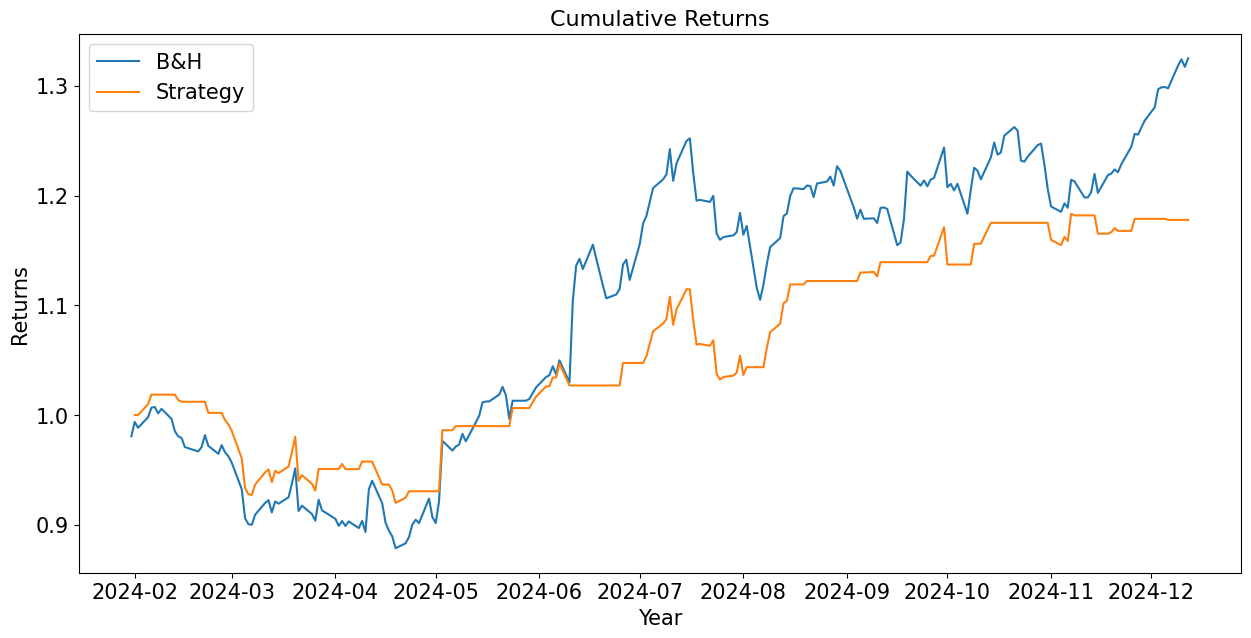

In [7]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative rets
plt.plot(results.index, results[['bh_cum_rets', 'stra_cum_rets']], label = ["B&H", "Strategy"])

# Set the title of the graph
plt.title('Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/strategy-returns.png', bbox_inches='tight')

Start date,2024-02-01
End date,2024-12-12
Total months,10
,Backtest
Annual return,41.398%
Cumulative returns,35.127%
Annual volatility,22.751%
Sharpe ratio,1.64
Calmar ratio,3.24
Stability,0.80
Max drawdown,-12.776%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.78,2024-02-07,2024-04-19,2024-05-15,71
1,11.75,2024-07-16,2024-08-06,2024-10-18,69
2,6.12,2024-10-21,2024-11-04,2024-11-29,30
3,4.24,2024-06-17,2024-06-21,2024-07-01,11
4,2.84,2024-05-21,2024-05-23,2024-06-03,10


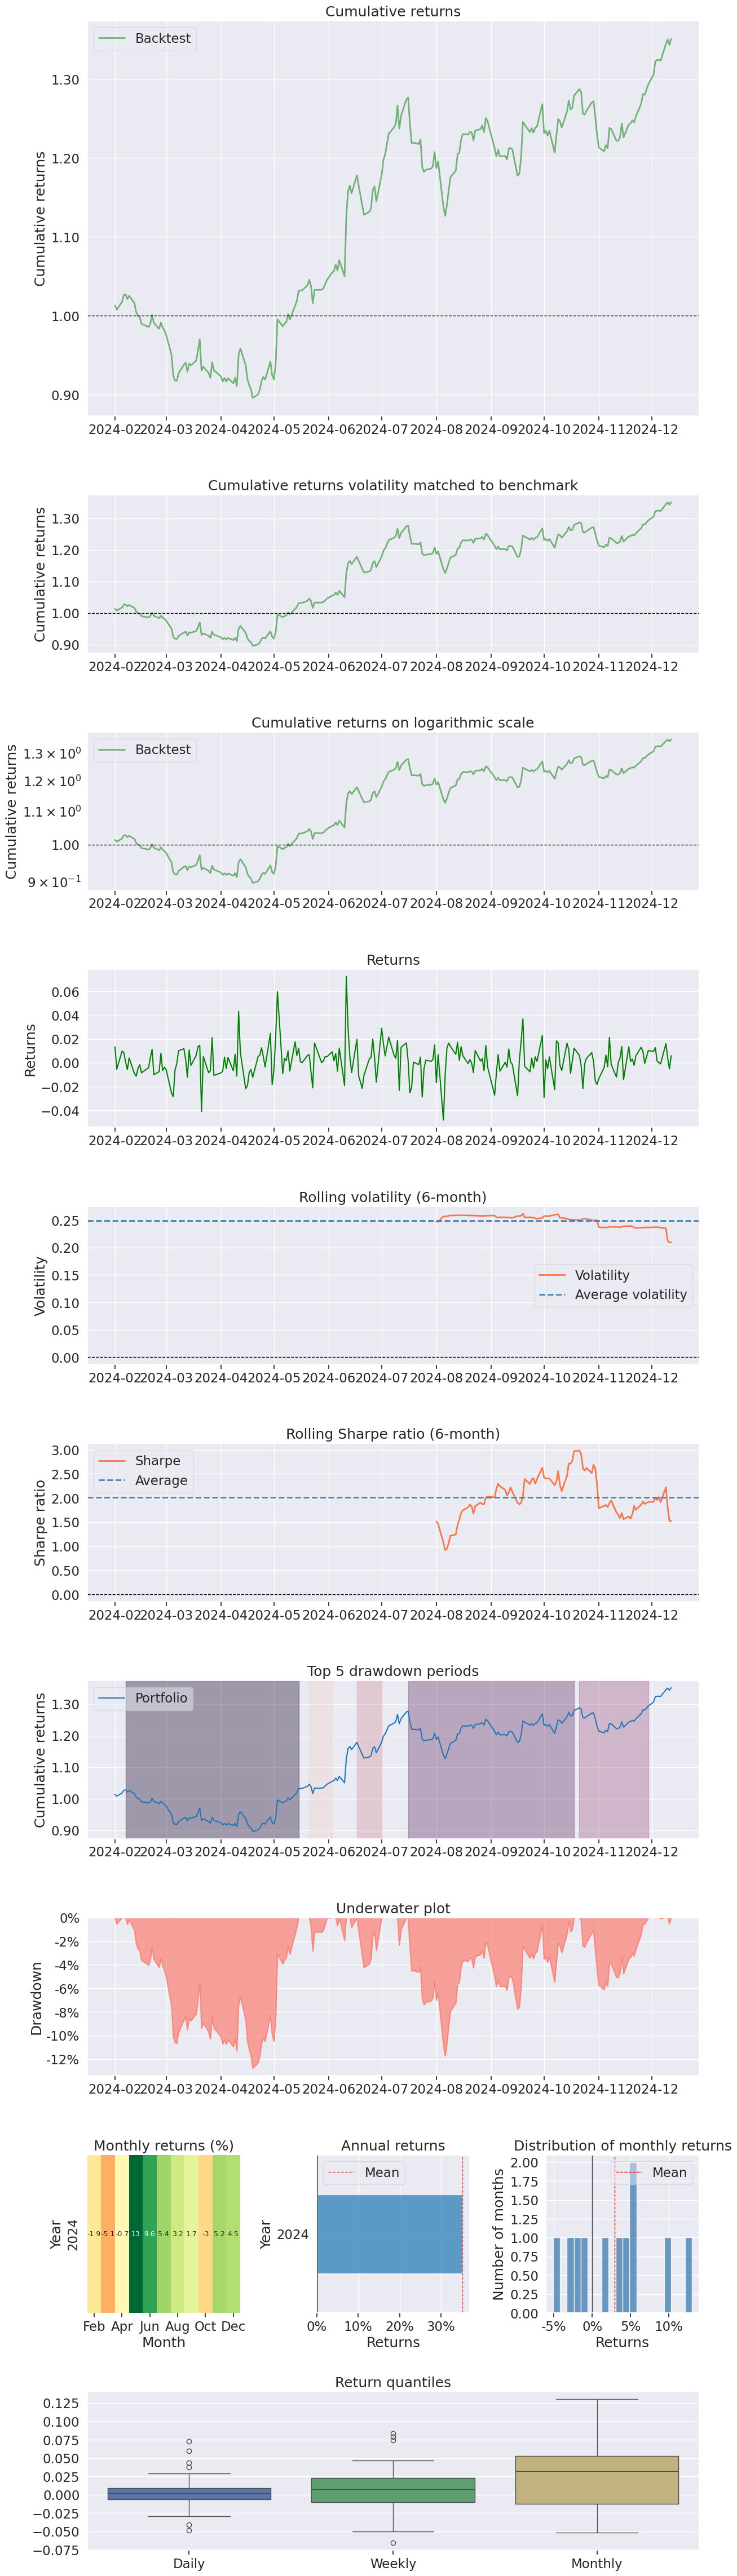

In [8]:
# Create the trading tear sheet for the Buy-and-Hold cumulative returns
pf.create_full_tear_sheet(results['bh_cum_rets'].pct_change().dropna())

Start date,2024-02-02
End date,2024-12-12
Total months,10
,Backtest
Annual return,20.824%
Cumulative returns,17.779%
Annual volatility,14.987%
Sharpe ratio,1.34
Calmar ratio,2.15
Stability,0.83
Max drawdown,-9.687%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.69,2024-02-13,2024-04-19,2024-06-03,80
1,7.38,2024-07-16,2024-07-25,2024-08-15,23
2,2.91,2024-09-30,2024-10-01,2024-10-14,11
3,2.32,2024-07-10,2024-07-11,2024-07-15,4
4,1.91,2024-06-07,2024-06-10,2024-06-26,14


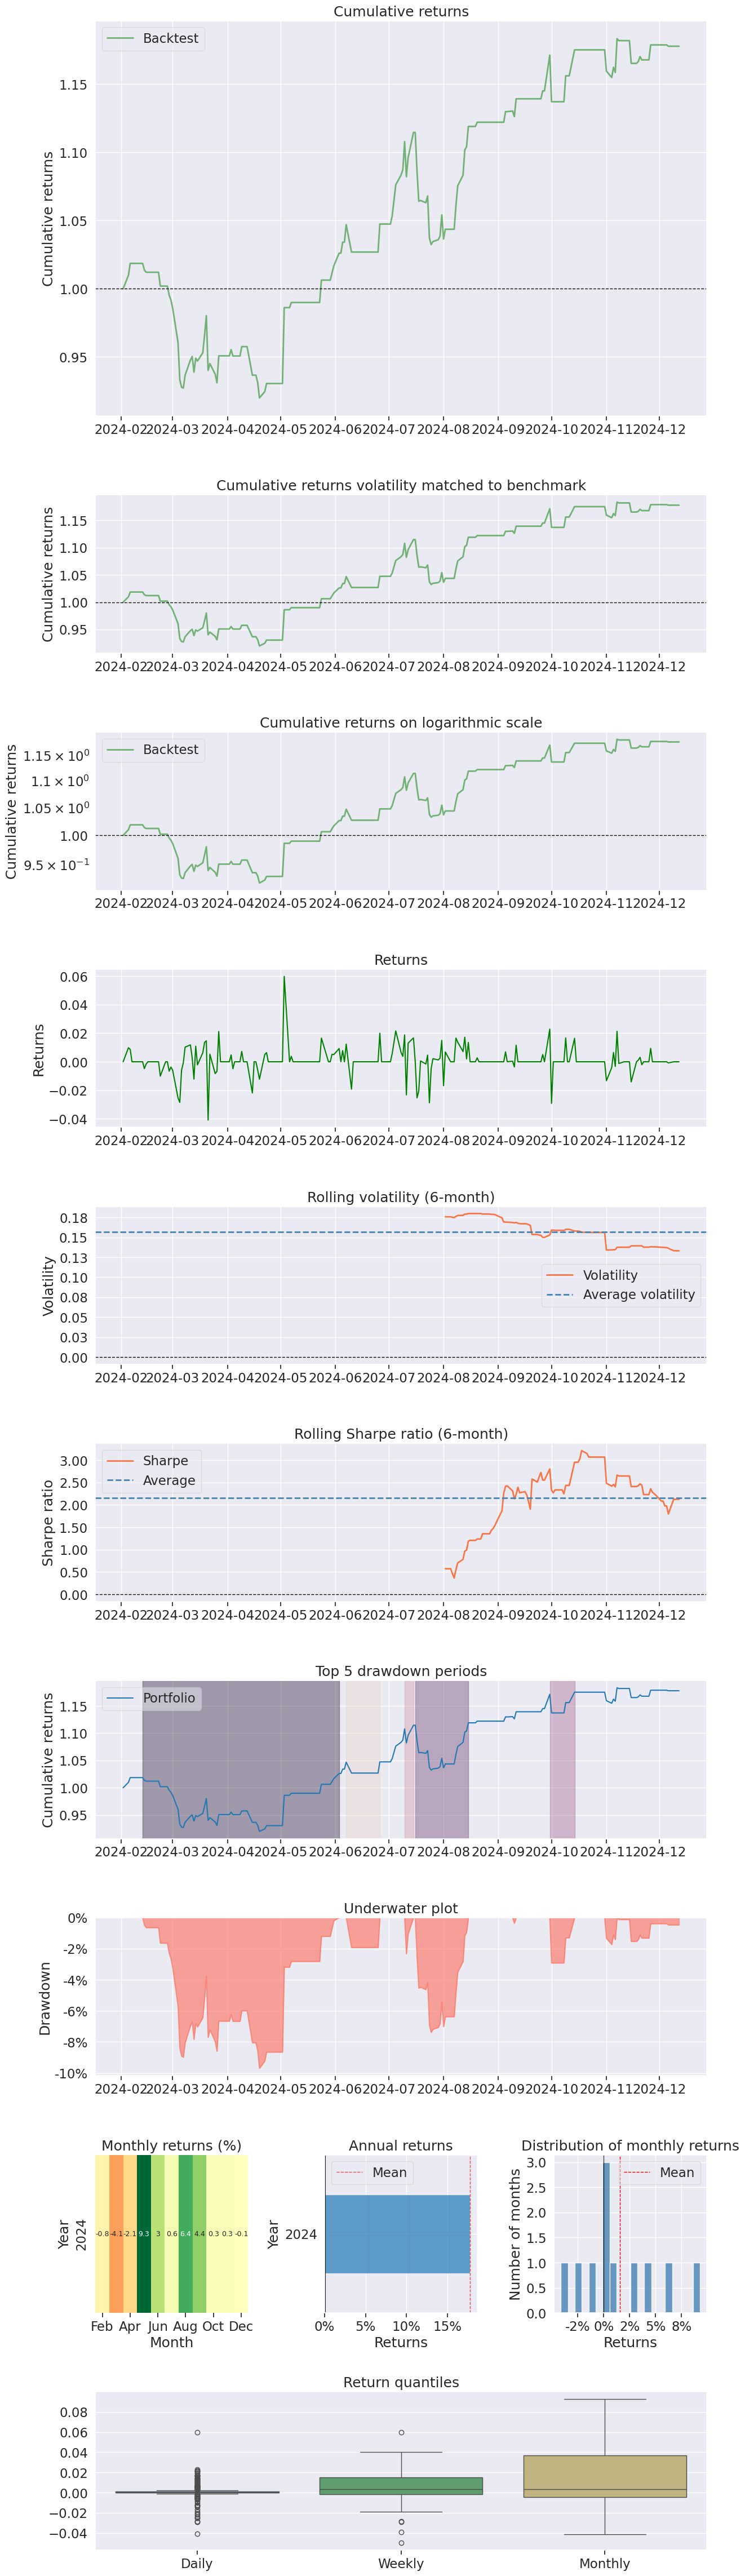

In [9]:
# Create the trading tear sheet for the strategy cumulative returns
pf.create_full_tear_sheet(results['stra_cum_rets'].pct_change().dropna())